In [1]:
%matplotlib inline
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import itertools as it
import calcs as c
import pickle
from os.path import exists

## Subproject 1

<b>Problem 1</b>: For a 3 $\times$ 3 lattice, there are $2^9$ configurations possible.

In [2]:
configs = 2**9
print("There are " + str(configs) + " configurations.")

There are 512 configurations.


<b>Problem 2:</b> The code for this is found in the <i>calcs.py</i> file and enumerates all possible configurations.

In [3]:
# creating the lattice (code is in the calcs.py file)
lattices = c.create_lattices()

In [4]:
# Here is a sample
print(lattices[:, :, 100])

[[ 1.  1. -1.]
 [-1.  1.  1.]
 [-1.  1.  1.]]


<b>Problem 3:</b> The code for this is given by the "hammy" function in the <i>calcs.py</i> file.

<b>Problem 4:</b> Using the code in <b>3</b> to calculate the partition function and internal energy of the lattice at $T=0.1$ K and $T=1000$ K.

In [5]:
J, H = 1.0, 0.0
T = [0.1, 1000.0]
Q_lo_T, avg_lo = c.get_Q_and_E(0.1, 1.0, 0.0, lattices)
Q_hi_T, avg_hi = c.get_Q_and_E(1000.0, 1.0, 0.0, lattices)

In [6]:
print("The average energy in the low temperature limit is: " + str(avg_lo)[0:9] + ".")
print("The average energy in the high temperature limit is: " + str(avg_hi)[0:9] + ".")
print("The partition function in the low temperature limit is: "
      + str(Q_lo_T)[0:9] + str(Q_lo_T)[-4:] + ".")
print("The partition function in the high temperature limit is: " + str(Q_hi_T)[0:9] + ".")

The average energy in the low temperature limit is: -18.0.
The average energy in the high temperature limit is: -0.018018.
The partition function in the low temperature limit is: 2.9787684e+78.
The partition function in the high temperature limit is: 512.00461.


<b>Explanation:</b> In the low $T$ limit, I would expect $Q$ to blow up to infinity as we are summing exponentials with exponents dependent on inverse temperature. In the high $T$ limit, I would expect $Q$ to approach $512$ because $1/kT \rightarrow 0$ as $T \rightarrow \infty$, making $Q$ approximately equivalent to adding $1$ to itself $512$ times. These results are in agreement with this mathematical argument.

## Subproject 2

<b>Problem 1</b>: Energy calculation using Onsager's solution for the internal energy of infinitely sized lattices. The expression used was
\begin{align*}
    U = - J \coth(2 \beta J) \left[ 1 + \dfrac{2}{\pi} \left( 2 \tanh^2(2 \beta J) - 1 \right) \int_0^{\pi/2}  \dfrac{{\rm d}\theta}{\sqrt{1-4k(1+k)^{-2}\sin^2\theta}} \right],
\end{align*}
where
\begin{align*}
    k = {\rm csch}^2(2 \beta J).
\end{align*}

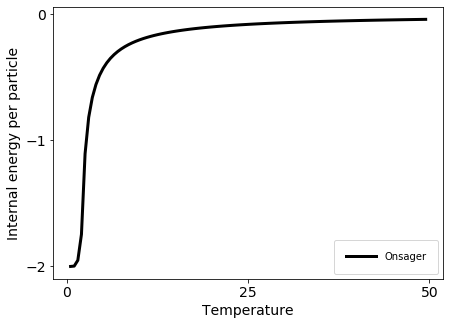

In [7]:
J = 1.0
T_ons, E_ons = c.onsager(J)
E_plt_list = [E_ons]
c.plt_onsager(T_ons, E_plt_list, "Onsager_final.pdf")

<b>Problem 2</b>: Calculating the enrgy per particle of the $3 \times 3$ lattice and comparing these data to Onsager's solution found in <i>Problem 1</i>.

In [8]:
E_array = np.zeros_like(T_ons, float)
for k in range(T_ons.shape[-1]):
    Temp = T_ons[k]
    E_array[k] = c.get_Q_and_E(Temp, 1.0, 0.0, lattices, True)[1]

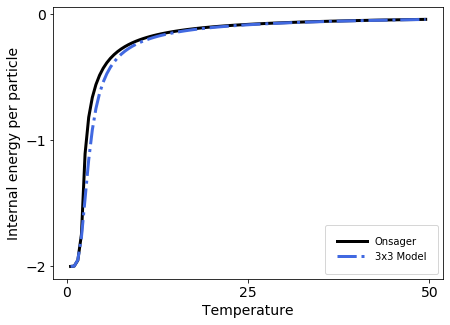

In [9]:
E_plt_list.append(E_array)
c.plt_onsager(T_ons, E_plt_list, "OnsagerVs3x3_final.pdf")

As we can observe from the above plot, the results from the $3 \times 3$ modelare in agreement with Onsager's analytical expression. To see where things break down, let's view the plot of their absolute difference in the plot below. We can see that the $3 \times 3$ model does not capture the physics at temperatures between (approximately) $T=2$ and $T=20$ as well as it captures the physics at higher temperatures. This is due to the fact that Onsager's solution is derived for lattices of infinite sizes, whereas the solution that we have computed in this exercise is a $3 \times 3$ lattice (which is far from infinite). I hypothesize that this error would reduce as the lattice size is increased.

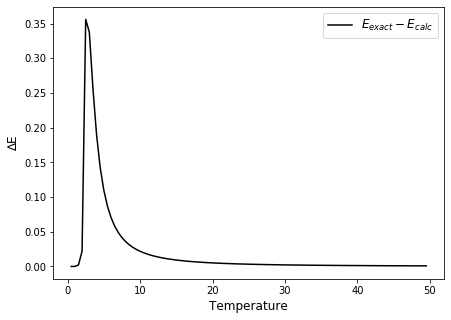

In [10]:
plt.figure(0, figsize=(7, 5))
plt.plot(T_ons, np.abs(E_ons - E_array), c="black", label="$E_{exact} - E_{calc}$")
plt.xlabel("Temperature", fontsize=12)
plt.ylabel("∆E", fontsize=12)
plt.legend(loc="upper right", fontsize=12)
#plt.savefig("comparison_to_exact_final.pdf")
plt.show()

## Subproject 3

<b>Problem 1</b>: The <i>rnd()</i> function in <i>calcs.py</i> returns either $-1$ or $+1$ at random. The code is explained within the function docstring.

In [11]:
# example of how to use the function
print(c.rnd())

1


<b>Problem 2</b>: The <i>rndN()</i> function in <i>calcs.py</i> returns two random integers $i$ and $j$ that are between 0 and $N$, where $N \times N$ is the size of the lattice.

In [12]:
# example of how to use the function
print(c.rndN(10))

(7, 10)


In [13]:
# Sanity check: comparison to results from subproject 1
Ts = [0.1, 1000]
words = ["low temp E:", "high temp E:"]
for k in range(2):
    params = {"dim":3, "kb":1.0, "Temperature":Ts[k],
              "J":1.0, "H":0.0, "n_iter":100000,
              "matrix":False}
    E, M = c.MCMC(params)
    avg_E = np.sum(E) / E.shape[0]
    print(words[k], avg_E)
print("---------------------")

low temp E: -17.99752
high temp E: -0.00496
---------------------


<b>Problem 4</b>: Sampling the $3 \times 3$ lattice with $J = k_{\rm B}$, $H=0$, and $T=10$. These parameters are loaded into the params dictionary and then passed to the MCMC function.

In [14]:
params_four = {"dim":3, "kb":1.0, "Temperature":10,
               "J":1.0, "H":0.0, "n_iter":100000, 
               "matrix":False}
E_four, M_four = c.MCMC(params_four)
avg_E_four = np.sum(E_four) / E_four.shape[0]
avg_M_four = np.sum(M_four) / M_four.shape[0]
print("The average energy is: " + str(avg_E_four)[0:7] + ".")

The average energy is: -1.9552.


<b>Problem 4</b>: (continued) Utilizing binning analysis to calculate the error bars on the energies.

In [15]:
val = E_four
N = E_four.shape[0]
stddevs = np.zeros((10,))
binSize = 1.0 * stddevs
for i in range(10):
    L = 2**i
    nbin = N//2**i
    stddevs[i] = c.binning(val, L) / (nbin)**0.5
    binSize[i] = L

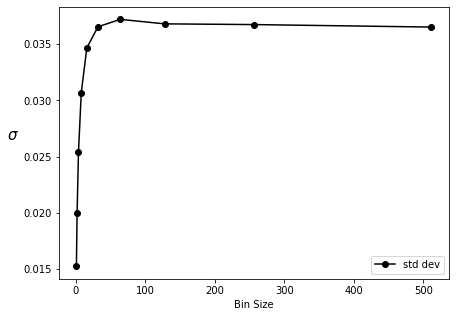

In [16]:
# binning analysis plot
c.pltBins(binSize, stddevs, "std_final.pdf")

From the above plot, we can see that the errors do converge as the bin size becomes larger.

In [17]:
# estimate for error as well as upper and lower bounds of error
er_est = stddevs[-1]
lb = avg_E_four - er_est
ub = avg_E_four + er_est
print("The lower bound is: " + str(lb)[0:7] + ".")
print("The upper bound is: " + str(ub)[0:7] + ".")

The lower bound is: -1.9917.
The upper bound is: -1.9186.


In this next section, I will show, using error analysis, that my solution agrees with the exact result. The MCMC algorithm is used to compute the average energy in the low temperature limit, $T=0.1$, which is then compared to the result in subproject 1.

In [18]:
params_chk = {"dim":3, "kb":1.0, "Temperature":0.1,
               "J":1.0, "H":0.0, "n_iter":100000, 
               "matrix":False}
E_chk, M_chk = c.MCMC(params_chk)
avg_E_chk = np.sum(E_chk) / E_chk.shape[0]
avg_M_chk = np.sum(M_chk) / M_chk.shape[0]
print("The average energy is: " + str(avg_E_chk)[0:7] + ".")

val = E_chk
N = E_chk.shape[0]
stddevs = np.zeros((10,))
binSize = 1.0 * stddevs
for i in range(10):
    L = 2**i
    nbin = N//2**i
    stddevs[i] = c.binning(val, L) / (nbin)**0.5
    binSize[i] = L

er_est = stddevs[-1]
lb = avg_E_chk - er_est
ub = avg_E_chk + er_est
print("The lower bound is: " + str(lb)[0:7] + ".")
print("The upper bound is: " + str(ub)[0:7] + ".")
print("The result found in part 1 is: " + str(avg_lo)[0:9] + ".")
if (np.isclose(ub, avg_lo) or np.isclose(lb, avg_lo)):
    print("There is agreement within the computed error bars.")

The average energy is: -17.999.
The lower bound is: -17.999.
The upper bound is: -17.998.
The result found in part 1 is: -18.0.
There is agreement within the computed error bars.


<b>Problem 5</b>: Running code for a $10 \times 10$ lattice. The function called <i>rnd_lattice()</i> creates a random $N \times N$ lattice and is found in the <i>calcs.py</i> file. 

In [19]:
# create a random 10 x 10 lattice
big_lettuce = c.rnd_lattice(10)

In [20]:
# running code for the 10 x 10 lattice at T=10
params_five = {"dim":10, "kb":1.0, "Temperature":10.0,
               "J":1.0, "H":0.0, "n_iter":10000, 
               "matrix":big_lettuce}
E_five, M_five = c.MCMC(params_five)
avg_E_five = np.sum(E_five) / E_five.shape[0]
avg_M_five = np.sum(M_five) / M_five.shape[0]

The Onsager solution at $T=10.0$ compared to my solution.

In [21]:
# comparison to the Onsager solution
T_ten_ons = np.where(T_ons == 10.0)[0][0]
print("The Onsager solution at T=10 is: " + str(E_ons[T_ten_ons]*100)[0:7] + ".")
print("My solution at T=10 is: " + str(avg_E_five)[0:7] + ".")
print("These results are clearly in close agreement.")

The Onsager solution at T=10 is: -20.337.
My solution at T=10 is: -19.486.
These results are clearly in close agreement.


<b>Problem 7</b>: The magnetization $M$ is calculated for three different values of magnetic field as a function of temperature.

In [22]:
T_array = np.array([0.1, 0.5, 1.0, 1.5, 2.0,
                    2.5, 3.0, 3.5, 5.0, 8.0])

To make this code easier to check, I have saved the actual data to a pickle file, which can be read and run without having to re-compute these arrrays. The first plot shown below was calculated with 100,000 iterations in the MCMC algorithm.

In [23]:
H_list = [0.0, 0.02, 0.1, 0.5]
if exists("./big_M_list.pkl"):
    with open(f"./big_M_list.pkl", "rb") as f:
        M_list = pickle.load(f)
else:
    M_list = []
    for k in H_list:
        T, E, M = c.TvM(k)
        M_list.append(M)
    with open(f"./M_list.pkl", "wb") as f:
        pickle.dump(M_list, f, pickle.HIGHEST_PROTOCOL)

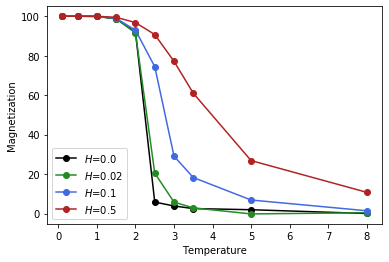

In [24]:
clrs = ["black", "forestgreen", "royalblue", "firebrick"]
for k in range(4):
    plt.plot(T_array, M_list[k],
             ls="-", marker="o",
             c=clrs[k],
             label="$H$="+str(H_list[k]))
    plt.ylabel("Magnetization")
    plt.xlabel("Temperature")
plt.legend(loc="lower left")
#plt.savefig("M_vs_T_100000_final.pdf")
plt.show()

These results do make sense. The general trend observed is that the overall orientation of the spins in the lattice becomes more disordered as temperature increases. However, as the magnetic field strength increases, order is maintained at higher temperatures which is in line with intuition developed in undergraduate chemistry courses when working with techniques such as NMR spectroscopy.

Another plot from the same code, using 10,000 iterations.

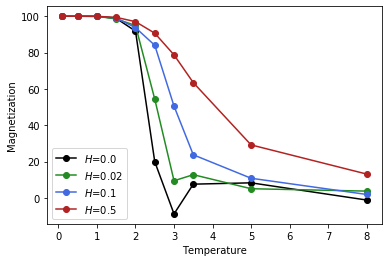

In [25]:
if exists("./big_M_list1.pkl"):
    with open(f"./big_M_list1.pkl", "rb") as f:
        M_list = pickle.load(f)
clrs = ["black", "forestgreen", "royalblue", "firebrick"]
for k in range(4):
    plt.plot(T_array, M_list[k],
             ls="-", marker="o",
             c=clrs[k],
             label="$H$="+str(H_list[k]))
    plt.ylabel("Magnetization")
    plt.xlabel("Temperature")
plt.legend(loc="lower left")
#plt.savefig("M_vs_T_10000_final.pdf")
plt.show()